In [908]:
import numpy as np
import matplotlib.pyplot as plt
import torch as torch
import torch
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.optim as optim
import torch
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch import sqrt
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython import display

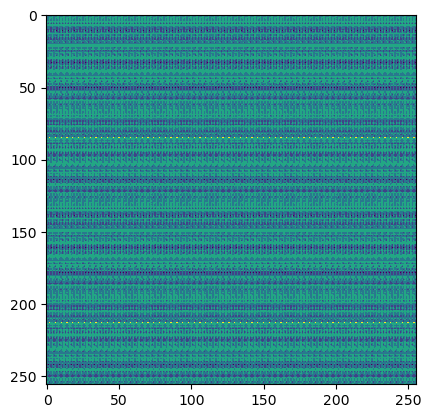

In [909]:
x0 = Variable(torch.randn(1,dtype=torch.complex64)*max_baseline, requires_grad=True)
y0 = Variable(torch.randn(1,dtype=torch.complex64)*max_baseline, requires_grad=True)
x1 = Variable(torch.randn(1,dtype=torch.complex64)*max_baseline, requires_grad=True)
y1 = Variable(torch.randn(1,dtype=torch.complex64)*max_baseline, requires_grad=True)
x2 = Variable(torch.randn(1,dtype=torch.complex64)*max_baseline, requires_grad=True)
y2 = Variable(torch.randn(1,dtype=torch.complex64)*max_baseline, requires_grad=True)
x3 = Variable(torch.randn(1,dtype=torch.complex64)*max_baseline, requires_grad=True)
y3 = Variable(torch.randn(1,dtype=torch.complex64)*max_baseline, requires_grad=True)

width = 256
center_position=[128,128]
max_baseline = 4.0
center= max_baseline//2

def compute_baselines(x0,y0,x1,x2,x3,y1,y2,y3):
    
    b1=[(x0-x1),(y0-y1)]
    b2=[(x0-x2),(y0-y2)]
    b3=[(x0-x3),(y0-y3)]
    b4=[(x1-x0),(y1-y0)]
    b5=[(x1-x2),(y1-y2)]
    b6=[(x1-x3),(y1-y3)]
    b7=[(x2-x0),(y2-y0)]
    b8=[(x2-x1),(y2-y1)]
    b9=[(x2-x3),(y2-y3)]
    b10=[(x3-x0),(y3-y0)]  
    b11=[(x3-x1),(y3-y1)]
    b12=[(x3-x2),(y3-y2)]

    baselines_tensor = torch.stack([
        torch.tensor(b1), torch.tensor(b2), torch.tensor(b3),
        torch.tensor(b4), torch.tensor(b5), torch.tensor(b6),
        torch.tensor(b7), torch.tensor(b8), torch.tensor(b9),
        torch.tensor(b10), torch.tensor(b11), torch.tensor(b12)
    ])

    baselines_tensor.retain_grad
    
    return baselines_tensor


baselines=compute_baselines(x0,y0,x1,x2,x3,y1,y2,y3)


sky = torch.zeros((width, width), dtype=torch.complex64, requires_grad=True)
#sky[width//2, width//2]=1
#sky.retain_grad()


# Instead of in-place assignment, create a new tensor
sky = sky.clone()  # Create a copy to avoid in-place modification
sky[width // 2, width // 2] = 1

# Optionally retain gradients for debugging



#uv=torch.zeros((width,width),dtype=torch.complex64, requires_grad=True)

#for u, v in baselines:
       # u_index = int((u.real + max_baseline) * width / (2 * max_baseline))
        #v_index = int((v.real + max_baseline) * width / (2 * max_baseline))
        #if 0 <= u_index < width and 0 <= v_index < width:
           # uv[u_index, v_index] = 1


uv = torch.zeros((width, width), dtype=torch.complex64, requires_grad=True)

# Creating a new tensor instead of in-place modification
uv = uv.clone()
#u_index = 5  # Example index
#v_index = 5  # Example index

if 0 <= u_index < width and 0 <= v_index < width:
    new_uv = uv.clone()  # Create a new tensor to avoid in-place modification
    new_uv[u_index, v_index] = 1


sky=torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(new_uv)))

image = (torch.abs(sky))
image_np = image.detach().numpy()

plt.imshow(image_np)
plt.show()

# Create a circular mask
mask = torch.zeros((width, width), dtype=torch.complex64 )
cy, cx = center_position
y, x = torch.meshgrid(torch.arange(width), torch.arange(width))
mask = (x - cx)**2 + (y - cy)**2 <= 1**2

#masked_uv = sky * mask
#outofmask=sky-masked_uv

#nt_ratio=(torch.abs(torch.sum(torch.abs(outofmask))))/(torch.abs(torch.sum(torch.abs(masked_uv))))
#nt_ratio

In [910]:

optimizer = optim.SGD([x0, y0, x1, y1, x2, y2, x3, y3], lr=1)

steps = 500

loss_history = []

# Optimization loop
for step in range(steps):

    # Compute baselines
    baselines=compute_baselines(x0,y0,x1,x2,x3,y1,y2,y3)

    uv = torch.zeros((width, width), dtype=torch.complex64, requires_grad=True)

    # Creating a new tensor instead of in-place modification
    uv = uv.clone()
    #u_index = 5  # Example index
    #v_index = 5  # Example index

    if 0 <= u_index < width and 0 <= v_index < width:
        new_uv = uv.clone()  # Create a new tensor to avoid in-place modification
        new_uv[u_index, v_index] = 1
    
    #for u, v in baselines:
        #u_index = int((u.real + max_baseline) * width / (2 * max_baseline))
        #v_index = int((v.real + max_baseline) * width / (2 * max_baseline))
        #if 0 <= u_index < width and 0 <= v_index < width:
           # uv[u_index, v_index] = 1

            
    sky=torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(new_uv)))

    # Create a circular mask
    mask = torch.zeros((width, width), dtype=torch.complex64, requires_grad=True )
    cy, cx = center_position
    y, x = torch.meshgrid(torch.arange(width), torch.arange(width))
    mask = (x - cx)**2 + (y - cy)**2 <= 1**2

    masked_uv = sky * mask
    outofmask=sky-masked_uv

    nt_ratio=(torch.abs(torch.sum(torch.abs(outofmask))))/(torch.abs(torch.sum(torch.abs(masked_uv))))
    #nt_ratio=-(torch.abs(outofmask))
    
    loss = nt_ratio
    
    # Zero gradients
    optimizer.zero_grad()
    
    # Compute gradients
    loss.backward(retain_graph=True)
    #retain_graph=True

    # Update parameters
    optimizer.step()

    loss_history.append(loss.item())

    if step % 100 == 0:
        print(f'Step {step}: loss_history = {loss.item()}') # Prints a value for loss function once every hundred iterations






Step 0: loss_history = 13106.2001953125
Step 100: loss_history = 13106.2001953125
Step 200: loss_history = 13106.2001953125
Step 300: loss_history = 13106.2001953125
Step 400: loss_history = 13106.2001953125


In [911]:

#masked_uv_np = torch.abs(masked_uv).detach().numpy()

#plt.imshow((masked_uv_np))
#plt.show();

In [912]:
#outofmask_np = (torch.abs(outofmask)).detach().numpy()

#plt.imshow((outofmask_np))
#plt.show();

Init Coords
[-1.3546609-2.2947392j] [-6.8024635-3.0817404j]
[2.6663742-6.4699116j] [-3.7856941+2.9880886j]
[-0.53956825-2.0575686j] [0.12450884-0.8223205j]
[-0.3632915+0.51465493j] [1.7371607+3.4183967j]


/Users/georgebrown/anaconda3/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


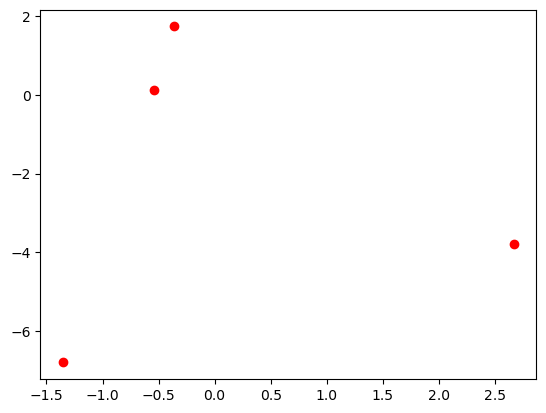

In [913]:
plt.plot(x0.detach().numpy(), y0.detach().numpy(), 'o', color='red',label="Initial Positions")
plt.plot(x1.detach().numpy(), y1.detach().numpy(), 'o', color='red')
plt.plot(x2.detach().numpy(), y2.detach().numpy(), 'o', color='red')
plt.plot(x3.detach().numpy(), y3.detach().numpy(), 'o', color='red')

print("Init Coords")
print(x0.detach().numpy(),y0.detach().numpy())
print(x2.detach().numpy(),y2.detach().numpy())
print(x1.detach().numpy(),y1.detach().numpy())
print(x3.detach().numpy(),y3.detach().numpy())

In [914]:

optimizer = optim.SGD([x0, y0, x1, y1, x2, y2, x3, y3], lr=1)


width = 256
max_baseline = 4.0
nant = 4
center_position=[128,128]
its=500


loss_history_=[]
# Optimization loop
for p in range(its):
 
    sky = torch.zeros((width, width), dtype=torch.complex64, requires_grad=True)
    sky = sky.clone()  # Create a copy to avoid in-place modification
    sky[width // 2, width // 2] = 1

    ant_pos = []
    for i in range(nant):
        x = torch.rand(1).item() * max_baseline
        y = torch.rand(1).item() * max_baseline
        ant_pos.append([x, y])
    

   

    baselines = [
        [ant_pos[0][0] - ant_pos[1][0], ant_pos[0][1] - ant_pos[1][1]],
        [ant_pos[0][0] - ant_pos[2][0], ant_pos[0][1] - ant_pos[2][1]],
        [ant_pos[0][0] - ant_pos[3][0], ant_pos[0][1] - ant_pos[3][1]],
        [ant_pos[1][0] - ant_pos[0][0], ant_pos[1][1] - ant_pos[0][1]],
        [ant_pos[1][0] - ant_pos[2][0], ant_pos[1][1] - ant_pos[2][1]],
        [ant_pos[1][0] - ant_pos[3][0], ant_pos[1][1] - ant_pos[3][1]],
        [ant_pos[2][0] - ant_pos[0][0], ant_pos[2][1] - ant_pos[0][1]],
        [ant_pos[2][0] - ant_pos[1][0], ant_pos[2][1] - ant_pos[1][1]],
        [ant_pos[2][0] - ant_pos[3][0], ant_pos[2][1] - ant_pos[3][1]],
        [ant_pos[3][0] - ant_pos[0][0], ant_pos[3][1] - ant_pos[0][1]],
        [ant_pos[3][0] - ant_pos[1][0], ant_pos[3][1] - ant_pos[1][1]],
        [ant_pos[3][0] - ant_pos[2][0], ant_pos[3][1] - ant_pos[2][1]],
    ]

    u_indices = [
        int((baselines[0][0] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[1][0] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[2][0] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[3][0] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[4][0] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[5][0] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[6][0] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[7][0] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[8][0] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[9][0] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[10][0] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[11][0] + max_baseline) * width / (2 * max_baseline)),
    ]

    v_indices = [
        int((baselines[0][1] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[1][1] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[2][1] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[3][1] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[4][1] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[5][1] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[6][1] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[7][1] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[8][1] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[9][1] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[10][1] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[11][1] + max_baseline) * width / (2 * max_baseline)),
    ]


    uv = torch.zeros((width, width), dtype=torch.complex64, requires_grad=True)

    # Creating a new tensor instead of in-place modification
    uv = uv.clone()
    #u_index = 5  # Example index
    #v_index = 5  # Example index

    if 0 <= u_index < width and 0 <= v_index < width:
        new_uv = uv.clone()  # Create a new tensor to avoid in-place modification
        new_uv[u_index, v_index] = 1



    sky_image = torch.fft.ifftshift(torch.fft.ifft2(torch.fft.fftshift(new_uv)))

    radius = 1  # Radius of the circular mask

    # Create a circular mask
    mask = torch.zeros((width, width), dtype=torch.bool, )
    cy, cx = center_position
    y, x = torch.meshgrid(torch.arange(width), torch.arange(width))
    mask = (x - cx)**2 + (y - cy)**2 <= radius**2

    masked_uv = sky_image * mask
    outofmask=sky_image-masked_uv

    nt_ratio=(torch.abs(torch.sum(torch.abs(outofmask))))/(torch.abs(torch.sum(torch.abs(masked_uv))))
        
    loss_8 = nt_ratio
    
    # Zero gradients
    optimizer.zero_grad()
    
    # Compute gradients
    loss_8.backward(retain_graph=True)
    #retain_graph=True

    # Update parameters
    optimizer.step()

    loss_history_.append(loss_8.item())

    if step % 100 == 0:
        print(f'Step {step}: loss_history_ = {loss_8.item()}') # Prints a value for loss function once every hundred iterations

    



In [915]:
loss_history_

[13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.2001953125,
 13106.20019

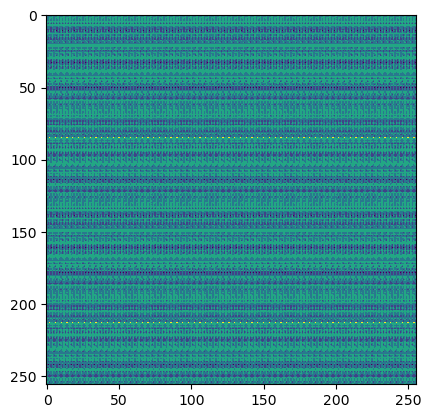

In [916]:
images = (np.abs(sky_image.detach().numpy()))
plt.imshow(images)
plt.show()